In [2]:
%load_ext autoreload
%autoreload 2

## Basic setup

In [3]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

data_dir = Path('../data/CBCEcombineN2')
data_dir.mkdir(parents=True, exist_ok=True)
import time
from pathlib import Path
proj_name = "CBCEcombineN2"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
proj_name = "CBCEcombineN2"
file_name = "CBCEcombineN2"
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
file_suffix = f"{time.strftime('%b%d-%H%M')}"
seed = 0

In [ ]:
n2_adata = sc.read_h5ad('../data/celegans_binyamin/N2_outs/concord_celN2_Jun12-1457.h5ad')
cbce_adata = sc.read_h5ad('../data/CE_CB/adata_cbce_Jan30-1028.h5ad')

In [ ]:
n2_adata.obs['embryo.time'] = n2_adata.obs['raw.embryo.time']
n2_adata.obs['batch'] = 'BZ_N2'
n2_adata.obs['batch_fine'] = 'BZ_N2'
n2_adata.obs['batch_broad'] = 'BZ_N2'
n2_adata.obs['species'] = 'C.elegans'
n2_adata.obs_names = [f"{name}-BZ_N2" for name in n2_adata.obs_names]

cbce_adata.obs['batch_fine'] = cbce_adata.obs['batch'].copy()
cbce_adata.obs['batch_broad'] = cbce_adata.obs['dataset3'].astype(str).copy()
adata = cbce_adata.concatenate(n2_adata, batch_key='lab', batch_categories=['Murray_CBCE','Gartner_BZ'])
adata.X = adata.layers["counts"].copy()
# Compute basic statistics
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata.obs['batch'] = adata.obs['batch_broad'].copy()
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000, subset=False)
sc.tl.pca(adata, n_comps=300, svd_solver='arpack', use_highly_variable=True)

adata.write_h5ad(data_dir / f"{proj_name}_{file_suffix}.h5ad") # Save the adata object with the encoded embeddings
print(f"Saved adata to {data_dir / f'{proj_name}_{file_suffix}.h5ad'}")

Saved adata to ../data/CBCEcombineN2/CBCEcombineN2_Jun28-1823.h5ad


In [ ]:
# Save Packer dataset + N2 dataset separately
unique_batches = adata.obs['batch_broad'].unique()
print(f"Unique batches: {unique_batches}")
# If the batch name contains Waterston, Murray or BZ_N2, get it
filtered_batches = [batch for batch in unique_batches if 'Waterston' in batch or 'Murray' in batch or 'BZ_N2' in batch]
print(f"Filtered batches: {filtered_batches}")
adata_celsub = adata[adata.obs['batch_broad'].isin(filtered_batches)].copy()
print(f"adata_celsub shape: {adata_celsub.shape}")
adata_celsub.write_h5ad(data_dir / f"adata_celsub_{file_suffix}.h5ad")
print(f"Saved adata_celsub to {data_dir / f'adata_celsub_{file_suffix}.h5ad'}")

Unique batches: ['Waterston_300_minutes', 'Waterston_400_minutes', 'Waterston_500_1_minutes', 'Waterston_500_2_minutes', 'Ce_M03D44_300_minutes', ..., 'batch_300', 'batch_360', 'batch_400', 'batch_500', 'BZ_N2']
Length: 22
Categories (22, object): ['BZ_N2', 'Ce_M03D44_300_minutes', 'Ce_M03D44_500_minutes', 'Ce_ceh9_300_minutes', ..., 'batch_300', 'batch_360', 'batch_400', 'batch_500']
Filtered batches: ['Waterston_300_minutes', 'Waterston_400_minutes', 'Waterston_500_1_minutes', 'Waterston_500_2_minutes', 'Murray_b01', 'Murray_b02', 'Murray_r17', 'BZ_N2']
adata_celsub shape: (94276, 13405)


### Run pipeline

In [4]:
adata = sc.read_h5ad("../data/CBCEcombineN2/CBCEcombineN2_Jun28-1823.h5ad")

In [ ]:
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

In [28]:
ccd.ul.anndata_to_viscello(adata,
                        output_dir=data_dir / f"viscello_{proj_name}",
                        project_name=proj_name,
                        organism='cel')

VisCello project created at ../data/CBCEcombineN2/viscello_CBCEcombineN2


#### Create jobs

In [ ]:
adata = sc.read_h5ad(data_dir / f"{proj_name}_preprocessed.h5ad")

In [6]:
# Check if nan in adata.obs['batch'], if so show the rows with nan
if adata.obs['batch'].isna().any():
    print("Rows with NaN in 'batch':")
    print(adata.obs[adata.obs['batch'].isna()])

In [3]:
concord_args = {
        'element_mask_prob': 0.4, # Probability of masking features, recommended to be between 0.2 and 0.5
        'feature_mask_prob': 0.2, # Probability of masking features, recommended to be between 0.2 and 0.5
        'clr_temperature': 0.4, # Temperature for contrastive loss, recommended to be between 0.1 and 0.5
        'n_epochs': 15, # Number of epochs for training, adjust as needed
        'save_dir': '../'+str(save_dir) # Directory to save the model and results
    }

In [7]:
import subprocess, json
py_methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
py_methods = ["scvi", "concord_hcl", "concord_knn", "contrastive", "harmony"]
output_dir = '../jobs'
device = 'auto'
#conda_env = 'cellpath'
conda_env = 'concord'
batch_key = 'batch'
state_key = 'None'
latent_dim = '300'  # Adjust as needed, but should match the encoder_dims in concord_args
subprocess.run([
    "python", "./generate_py_jobs.py",
    "--proj_name", proj_name,
    "--adata_filename", f"{file_name}_preprocessed.h5ad",
    "--methods", *py_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env,
    "--mem", "32G",  # Adjust memory as needed
    "--runtime", "1:00:00",
    "--concord_kwargs", json.dumps(concord_args),
    "--mode", "wynton"
])


✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_scvi.py
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_scvi.sh

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_concord_hcl.py
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_concord_hcl.sh

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_concord_knn.py
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_concord_knn.sh

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_contrastive.py
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_contrastive.sh

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_harmony.py
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_harmony.sh



CompletedProcess(args=['python', './generate_py_jobs.py', '--proj_name', 'CBCEcombineN2', '--adata_filename', 'CBCEcombineN2_preprocessed.h5ad', '--methods', 'scvi', 'concord_hcl', 'concord_knn', 'contrastive', 'harmony', '--batch_key', 'batch', '--state_key', 'None', '--latent_dim', '300', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'concord', '--mem', '32G', '--runtime', '1:00:00', '--concord_kwargs', '{"element_mask_prob": 0.4, "feature_mask_prob": 0.2, "clr_temperature": 0.4, "n_epochs": 15, "save_dir": "../../save/CBCEcombineN2"}', '--mode', 'wynton'], returncode=0)

In [8]:
proj_folder = Path(output_dir) / f"benchmark_{proj_name}"   # ../jobs/benchmark_<proj>
proj_folder.mkdir(exist_ok=True)                      # defensive

submit_all = proj_folder / f"submit_all_{proj_name}.sh"
with submit_all.open("w") as f:
    f.write("#!/bin/bash\n")
    f.write("# Auto-generated — submits every job for this project\n")
    f.write("# Run from this folder, or let the script cd into it.\n\n")
    f.write('cd "$(dirname "$0")"\n\n')          # ensures we’re in the right dir
    for sh_file in sorted(proj_folder.glob(f"benchmark_{proj_name}_*.sh")):
        f.write(f'qsub "{sh_file.name}"\n')

submit_all.chmod(0o755)
print(f"📌  Run “{submit_all}” to queue every job.")

📌  Run “../jobs/benchmark_CBCEcombineN2/submit_all_CBCEcombineN2.sh” to queue every job.


In [ ]:
# Generate script for Seurat
import subprocess
r_methods = ["seurat_cca", "seurat_rpca"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'cellpath'
batch_key = 'batch'
state_key = 'None'
latent_dim = '300' 
subprocess.run([
    "python", "./generate_seurat_script.py",
    "--proj_name", proj_name,
    "--eset_dir", '../'+ str(data_dir / f"viscello_{proj_name}"),   # <- folder w/ eset.rds
    "--methods", *r_methods,
    "--batch_key", batch_key,
    "--state_key", state_key,
    "--latent_dim", latent_dim,
    "--mem", "250G",  # Adjust memory as needed
    "--runtime", "72:00:00",
    "--output_dir", output_dir,
    "--device", device,
    "--conda_env", conda_env
])

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_seurat_cca.R
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_seurat_cca.sh

✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_seurat_rpca.R
✅ Generated: benchmark_CBCEcombineN2/benchmark_CBCEcombineN2_seurat_rpca.sh



CompletedProcess(args=['python', './generate_seurat_script.py', '--proj_name', 'CBCEcombineN2', '--eset_dir', '../../data/CBCEcombineN2/viscello_CBCEcombineN2', '--methods', 'seurat_cca', 'seurat_rpca', '--batch_key', 'batch', '--state_key', 'None', '--latent_dim', '300', '--mem', '250G', '--runtime', '72:00:00', '--output_dir', '../jobs', '--device', 'auto', '--conda_env', 'cellpath'], returncode=0)

In [9]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = proj_folder / f"submit_sequential_{proj_name}.sh"

sequential_template = f"""#!/usr/bin/env bash
set -euo pipefail
cd "$(dirname "$0")"            # work inside this folder (../jobs)
shopt -s nullglob

for job in benchmark_{proj_name}_*.py; do
  base=${{job%.py}}
  log="${{base}}.log"

  # ───────────────────────────────────────────────────────────────
  # skip if a previous run finished successfully
  # ───────────────────────────────────────────────────────────────
  if [[ -f "$log" ]] && grep -q "finished OK" "$log"; then
      echo ">>> SKIP $job  — already completed"
      continue
  fi

  echo ">>> $job   $(date)" | tee -a "$log"
  if python "$job" >>"$log" 2>&1; then
      echo ">>> finished OK" | tee -a "$log"
  else
      echo ">>> FAILED"      | tee -a "$log"
  fi
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue jobs sequentially.")


📌  Run “../jobs/benchmark_CBCEcombineN2/submit_sequential_CBCEcombineN2.sh” to queue jobs sequentially.


### Collect results

In [4]:
adata = sc.read_h5ad("../data/CBCEcombineN2/CBCEcombineN2_Jun28-1823.h5ad")

[⚠️ Warning] no runs found for seurat_cca
[⚠️ Warning] missing ../save/CBCEcombineN2/seurat_rpca_0706-1551/benchmark_log_0706-1551.tsv
✅ Benchmark summary saved to: ../save/dev_CBCEcombineN2-Jul16/benchmark_summary_Jul16-1817.tsv


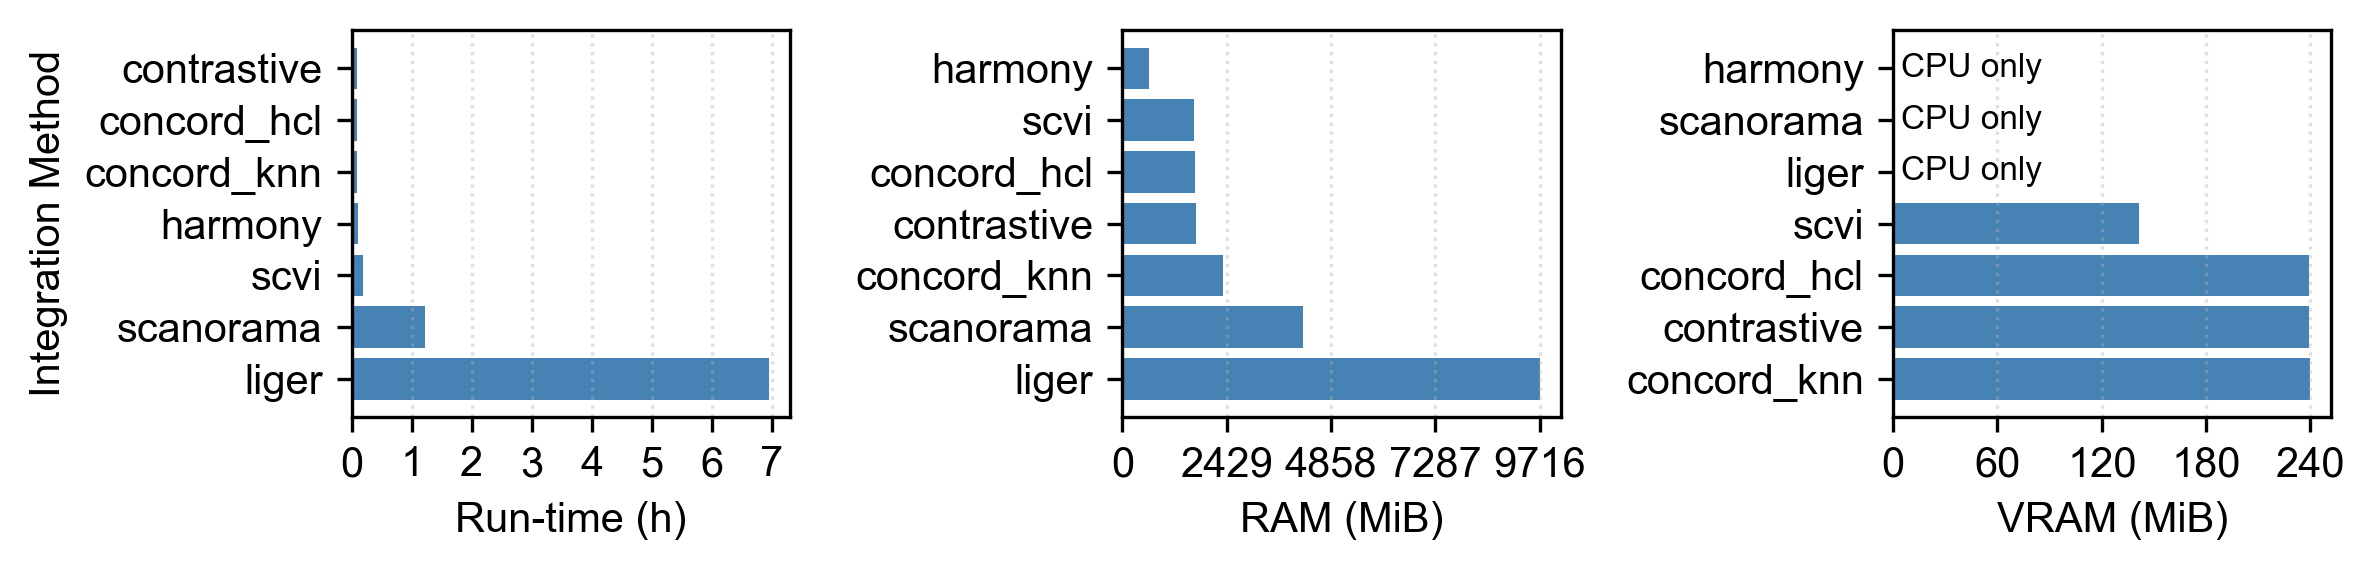

In [5]:
from benchmark_utils import collect_benchmark_logs
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"]

bench_df = collect_benchmark_logs(file_name, methods)
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf")


In [6]:
#methods = ["scvi", "harmony", "scanorama", "liger", "concord_hcl", "concord_knn", "contrastive", "seurat_cca", "seurat_rpca"] # "unintegrated",
from benchmark_utils import add_embeddings
methods= list(bench_df['method'].unique())
adata = add_embeddings(adata, proj_name=proj_name, methods=methods)

✅ obsm['scvi'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['liger'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded
✅ obsm['contrastive'] loaded


In [7]:
# Run umap for all latent embeddings
for basis in methods:
    print("Running UMAP for", basis)
    if basis not in adata.obsm:
        print(f"{basis} not found.")
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
    #ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_cosine', n_components=3, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
    #ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_cosine_3D', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)

# Save obsm 
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
adata.write_h5ad(data_dir / f"adata_final_{file_suffix}.h5ad")
print(f"✅ Saved adata with embeddings to {data_dir / f'adata_final_{file_suffix}.h5ad'}")

Running UMAP for scvi


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['scvi_UMAP_3D']
Running UMAP for harmony
concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['harmony_UMAP_3D']
Running UMAP for scanorama
concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['scanorama_UMAP_3D']
Running UMAP for liger
concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['liger_UMAP_3D']
Running UMAP for concord_hcl
concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['concord_hcl_UMAP_3D']
Running UMAP for concord_knn
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP']
concord - INFO - UMAP embedding stored in adata.obsm['concord_knn_UMAP_3D']
Running UMA

In [10]:
# Define color palette for broad_cell_type_qz
_, _, tissue_pal = ccd.pl.get_color_mapping(adata, 'broad_cell_type_qz', pal='Paired', seed=2)
_, _, species_pal = ccd.pl.get_color_mapping(adata, 'species', pal='Set1', seed=seed)
_, _, broadlin_pal = ccd.pl.get_color_mapping(adata,'broad_lineage', pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata,'dataset3', pal='Set1', seed=seed)
pal = {'embryo.time': 'BlueGreenRed', 
       "cell_type": 'Paired', 
       'species': species_pal, 
       'dataset3': batch_pal,
       'lineage_complete': 'Paired',
       'broad_lineage': broadlin_pal,
       'ct_or_lin': 'Paired', 
       'broad_cell_type_qz': tissue_pal, 
       'ct_or_broad_lin': 'Paired',
       'plot_cell_type': 'Paired',}


concord.plotting.pl_embedding - INFO - Plotting scvi with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with embryo.time in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with embryo.time in UMAP


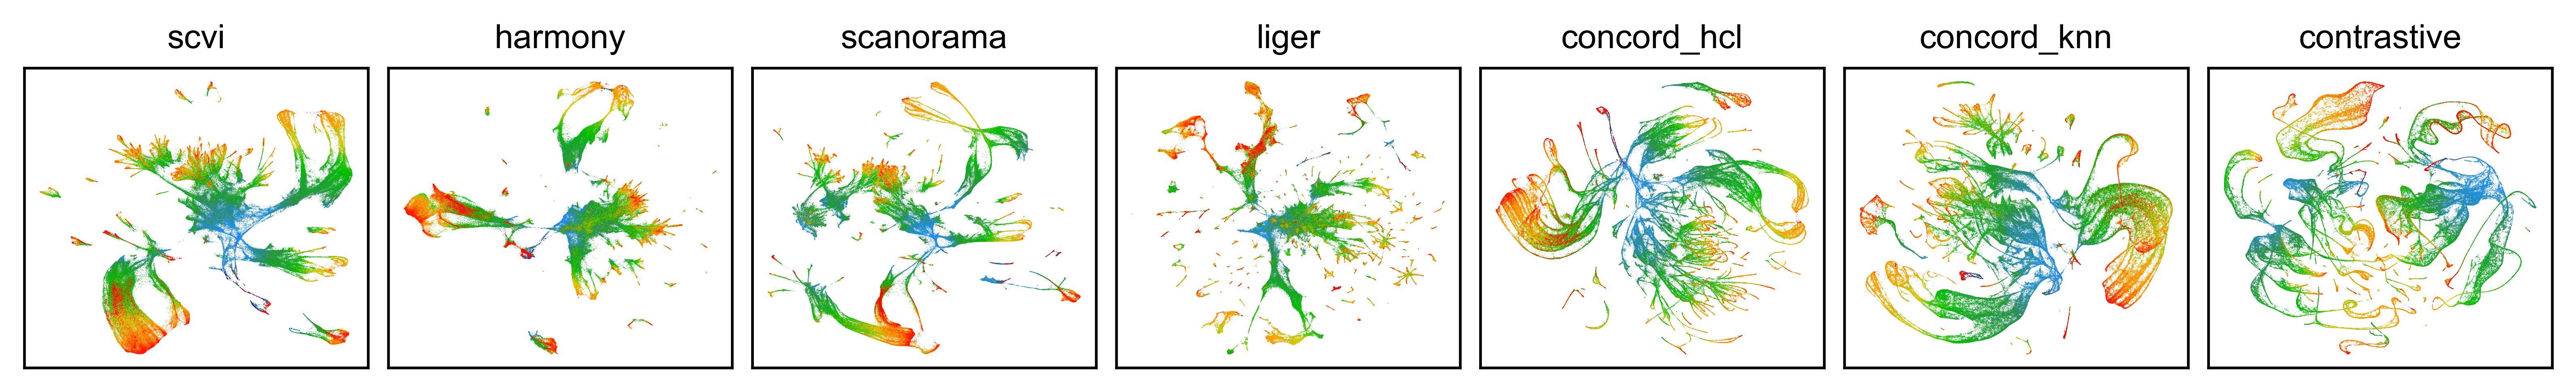

concord.plotting.pl_embedding - INFO - Plotting scvi with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting harmony with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting scanorama with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting liger with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_hcl with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting concord_knn with species in UMAP
concord.plotting.pl_embedding - INFO - Plotting contrastive with species in UMAP


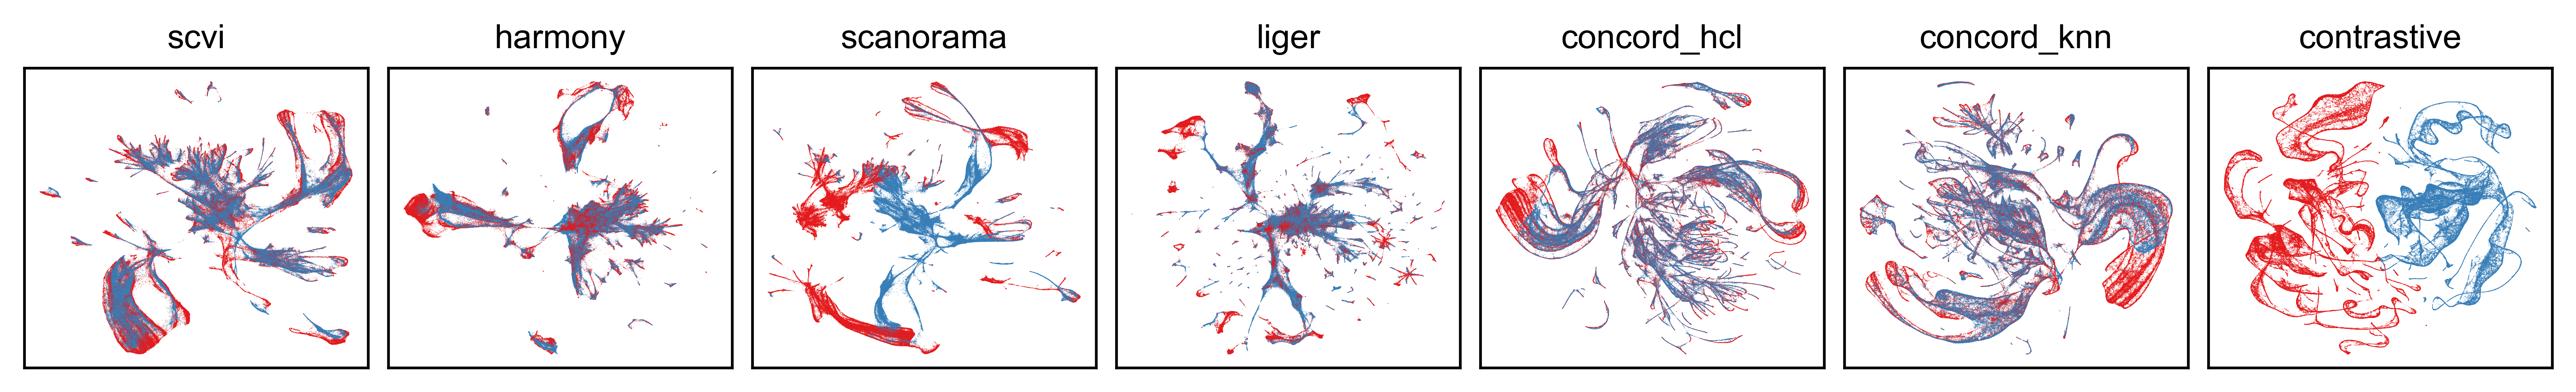

In [11]:
# plot everything
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = methods
show_cols = ['embryo.time', 'species']
#show_cols = ['lin_or_ct', 'ct_or_lin']
basis_types = ['UMAP']

font_size=10
point_size=.1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))


with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )
